In [40]:
import os
import numpy as np
import vtk
from vtk.util import numpy_support


import  matplotlib.pyplot as plt

from scipy import ndimage
from skimage import io, color, filters
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:


micro_image = io.imread("../target.png")
print(micro_image.shape)
print(type(micro_image))
# Convert the image to grayscale if it's in color
if micro_image.ndim == 3:
    micro_image = color.rgb2gray(micro_image)




micro_image = resize(micro_image, (micro_image.shape[0] // 4, micro_image.shape[1] // 4),
                       anti_aliasing=True)

(256, 256, 3)
<class 'numpy.ndarray'>


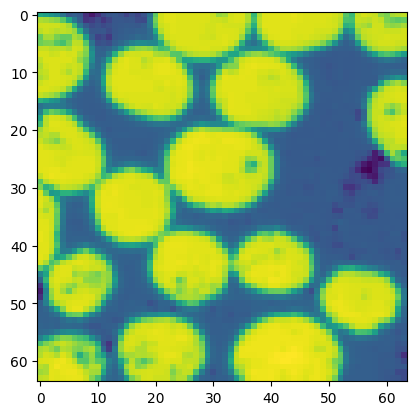

In [3]:
plt.imshow(micro_image)

In [4]:
array = np.array(micro_image)

In [5]:
# Use a thresholding method from skimage.filters
threshold_value = filters.threshold_otsu(array)

binary_array = array > threshold_value

In [6]:
# Fill holes in the binary image
binary_array = ndimage.binary_fill_holes(binary_array)

# Additional operations with ndimage (e.g., binary morphology)
binary_array= ndimage.binary_opening(binary_array)

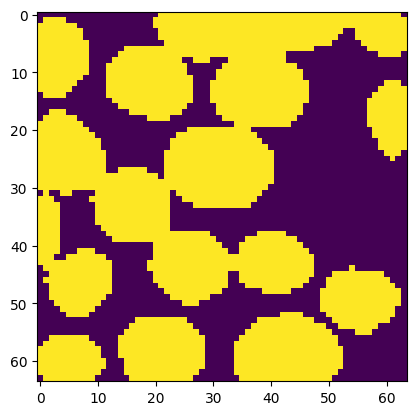

In [7]:
plt.imshow(binary_array)

In [8]:
binary_array = binary_array.astype(np.int16)
binary_array.shape

(64, 64)

In [9]:
# Copy along the third dimension to create a 3D array
three_d_array = np.tile(binary_array[:, :, np.newaxis], (1, 1, 1))
print(three_d_array.shape)

(64, 64, 1)


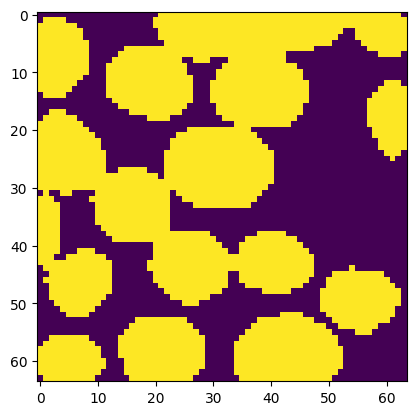

In [10]:
plt.imshow(three_d_array[:,:,0])

In [17]:
## SAVE DATA
## Convert the NumPy arrays to float32
scalar_data = three_d_array.transpose(0,1,2).astype(np.int64)


# Create a VTKImageData object
image_data = vtk.vtkImageData()
image_data.SetDimensions(tuple(x+1 for x in scalar_data.shape)) ## important add +1 to every dimension

# Flatten the scalar data
flat_scalar_data = scalar_data.flatten(order='F')
vtk_scalar_array = vtk.vtkLongArray()
vtk_scalar_array.SetNumberOfComponents(1)
vtk_scalar_array.SetArray(flat_scalar_data, len(flat_scalar_data), True)
vtk_scalar_array.SetName("material")

# Set the scalar data as cell data
image_data.GetCellData().SetScalars(vtk_scalar_array)



# Set the spacing and origin of the image data (you may need to adjust this based on your data)
image_data.SetSpacing(.14E-3, .14E-3, .14E-3) ## TODO set Spacing accordingly to voxel size
image_data.SetOrigin(0.0, 0.0, 0.0)

# Write the VTI file
writer = vtk.vtkXMLImageDataWriter()


writer.SetFileName("fiber_64x64x64.vti")
writer.SetInputData(image_data)

writer.Write()

1

In [38]:
import nrrd

In [39]:
nrrd.write('output.nrrd', three_d_array.transpose(0,1,2).astype(np.int64))

In [47]:
three_d_array.shape

(64, 64, 1)

In [59]:
import meshio
# Example material information (64x64x1)
material_data = three_d_array.reshape(-1).astype(np.int64)  # Flatten to match the number of vertices

# Generate material data corresponding to each vertex of the mesh
material_data = np.zeros((64, 64), dtype=np.int64)
for i in range(64):
    for j in range(64):
        material_data[i, j] = three_d_array[i, j, 0]


# Prepare points and cells
points = np.zeros((64 * 64, 3))
for i in range(64):
    for j in range(64):
        points[i * 64 + j] = [i, j, 0]

# Define the cells for a regular quad mesh
cells = [("quad", np.array([[i * 64 + j, 
                             i * 64 + j + 1, 
                             (i + 1) * 64 + j + 1, 
                             (i + 1) * 64 + j] for i in range(63) for j in range(63)]))]

# Write data to XDMF file
mesh = meshio.Mesh(points, cells)

mesh.cell_data["material"] = [material_data.flatten()]

mesh.points -= np.array([0, 0, 0])  # Set origin to (0, 0, 0)
mesh.points /= np.array([1, 1, 1])  # Set spacing to (1, 1, 1)

meshio.write("fiber_64x64x1.xdmf", mesh)